#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
%%capture
!pip install statsmodels pmdarima

In [2]:
# обработка и подготовка данных
import pandas as pd
import numpy as np
import torch
import itertools

# предобработка
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# валидация
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# моделирование
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import torch.nn as nn
import torch.optim as optim


# визуализация
import matplotlib.pyplot as plt
from tqdm import tqdm

# технические библиотеки
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'/datasets/taxi.csv')

In [4]:
# кратко изучим
df.info(), display(df.head());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
# надо преобразовать тип данных, и установить дату, как индекс
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [6]:
# отсортируем, если в этом есть потребность
if df.index.is_monotonic_increasing != True:
    df.sort_index(inplace=True)

In [7]:
# проведём ресемлирование по одному часу
df = df.resample('1H').sum()

**Вывод:**

С данными всё в порядке. Представленны данные в 10-минутном срезе, которые были ресемплированы в часой срез. Формат данных - правильный, сортировка - тоже, пропусков нет. Можно изучать временной ряд.

## Анализ

### Изучение стационарности

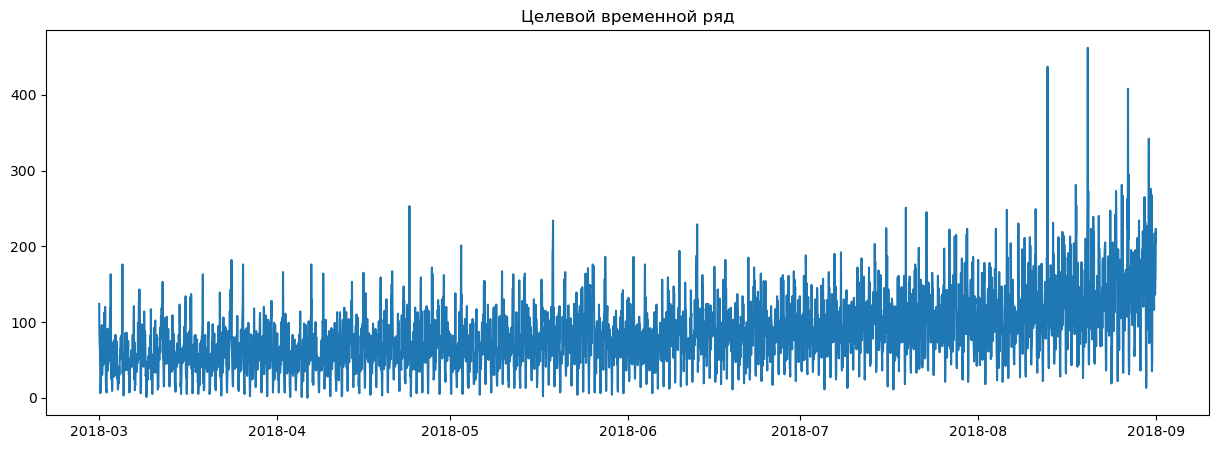

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(df)
plt.title('Целевой временной ряд')
plt.show()

**Временной ряд не стационанер. Что усложняет задачу прогнозирования. Тем не менее, преобразовывать его в стационарный мы не будем, поскольку в таком случае, тяжело будет интерпретировать результаты исследования.**

**Проверим сезонность и тренд:**

In [22]:
# Разложение временного ряда на компоненты
result = seasonal_decompose(df)

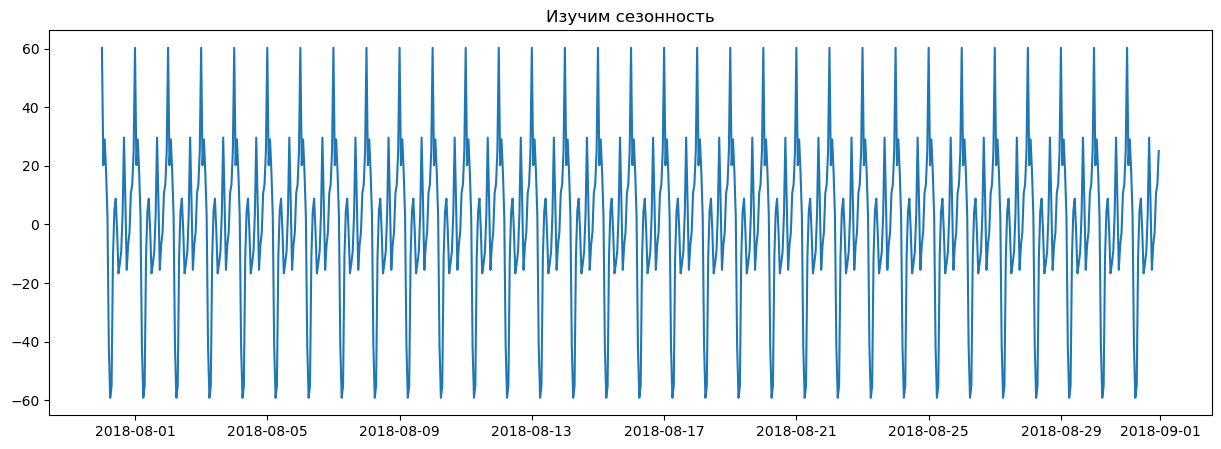

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(result.seasonal['2018-07-31':'2018-08-31'])
plt.title('Изучим сезонность')
plt.show()

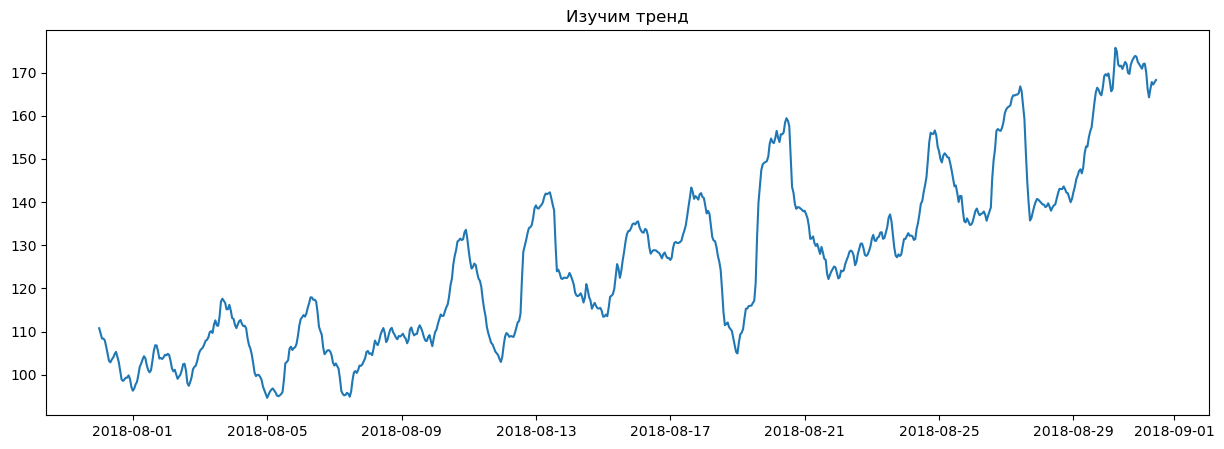

In [24]:
# Построение графика тренда
plt.figure(figsize=(15, 5))
plt.plot(result.trend['2018-07-31':'2018-08-31'])
plt.title('Изучим тренд')
plt.show()

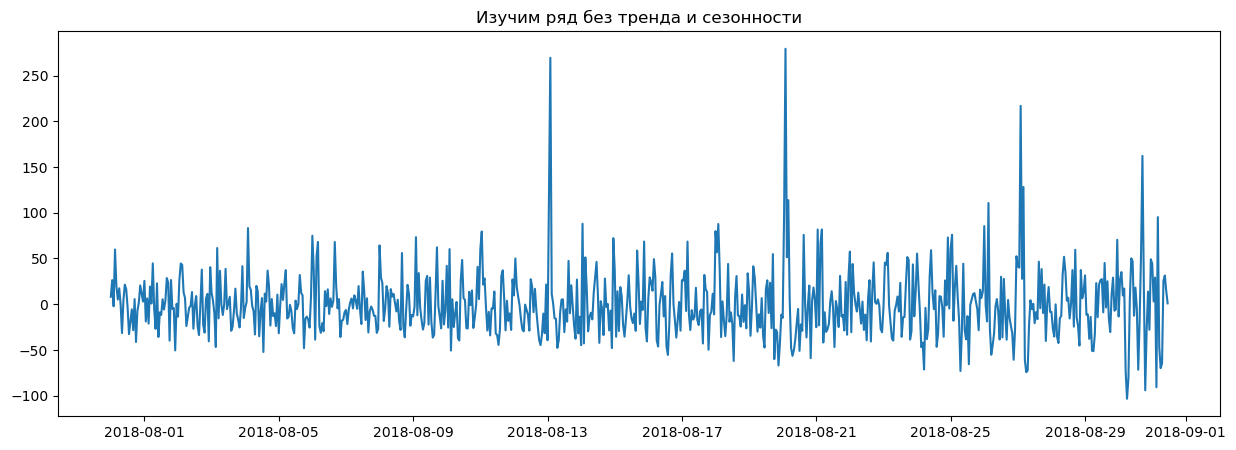

In [26]:
# Построение графика тренда
plt.figure(figsize=(15, 5))
plt.plot(result.resid['2018-07-31':'2018-08-31'])
plt.title('Изучим ряд без тренда и сезонности')
plt.show()

**Ряд сезонный, и, имеет восходящий тренд. При этом, ряд сам по себе статичный, нет статистических выбросов, которые сильно смещали бы статистику.**

**Попробуем проанализировать ряд базовыми методами:**

### Тестирование базовых методов

In [10]:
def split_function(df):
    '''
    Функция делит данные на 3 части для обучения, валидационные и тестовые.
    '''
    train, validation = train_test_split(df, shuffle=False, train_size=0.8)
    validation, test = train_test_split(validation, shuffle=False, train_size=0.5)
    return train, validation, test


train, validation, test = split_function(df)

In [11]:
def estimator_func(train, test, preds, model_name):
    '''
    Функция на входе получает 3 массива:
        1) train - известные данные;
        2) test - данные, которые нужно предсказать;
        3) preds - предсказания модели.
        
    Также на входе, функция получает название модели.
    
    На выходе функция:
        Строит график, отражающий, как модели удалось предсказать результаты, а также, возвращает rmse.
    '''
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    try:
        pred = pd.DataFrame({'preds': list((preds.reshape(len(test),)))}, index=test.index)
    except:
        pred = pd.DataFrame({'preds': preds}, index=test.index)
    plt.figure(figsize=(15, 5))
    plt.plot(train)
    plt.plot(test, alpha=0.5, color='black')
    plt.plot(pred, color='orange')
    plt.title(f'Тест модели: "{model_name}"')
    plt.legend(['train', 'test', 'preds'])
    plt.show()
    
    median_mse = mean_squared_error(preds, test[test.columns[0]]) 
    
    print(f'Модель "{model_name}", показала следующий результат RMSE: {round(np.sqrt(median_mse), 2)}')

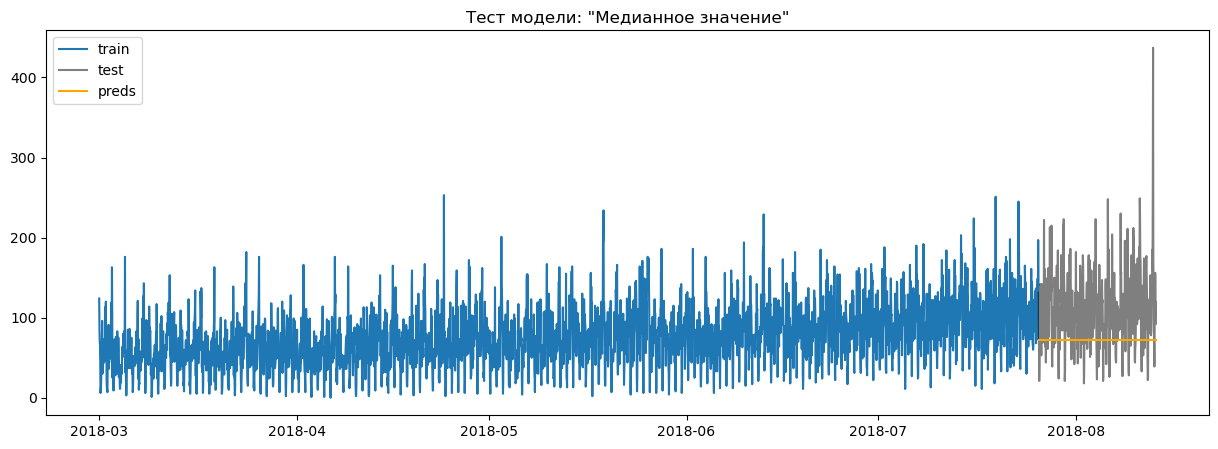

Модель "Медианное значение", показала следующий результат RMSE: 59.68


In [12]:
# проверим точность, если заполним результаты прогнозирования медианной:
pred_median = np.ones(validation.shape) * train.num_orders.median()
estimator_func(train, validation, pred_median, 'Медианное значение')

**Эта модель совсем не эффективна.**
**Попробуем модель, которая будет передавать последнее значение:**

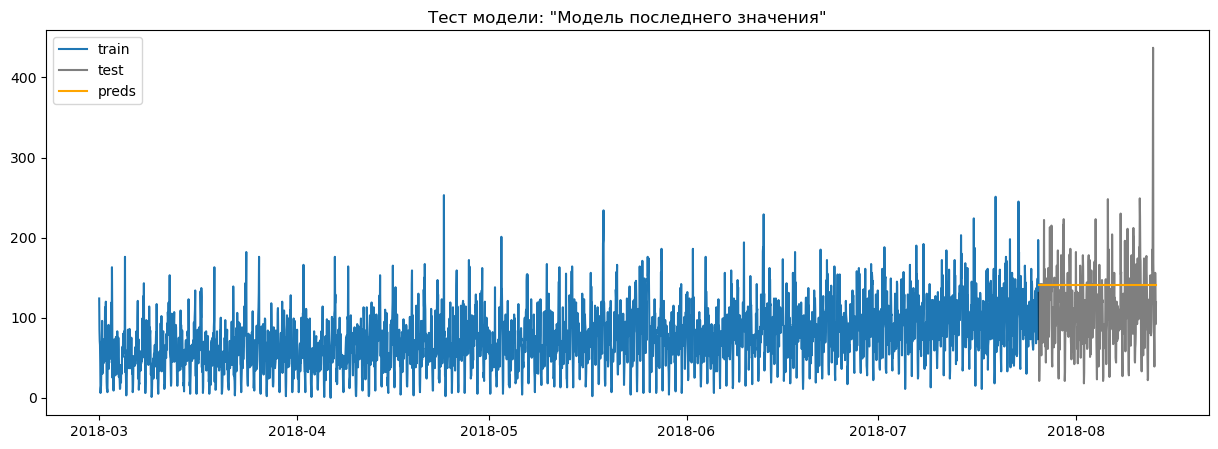

Модель "Модель последнего значения", показала следующий результат RMSE: 55.34


In [13]:
pred_previous = np.ones(validation.shape) * train.iloc[-1:, 0].values[0]
estimator_func(train, validation, pred_previous, 'Модель последнего значения')

**Модель, предсказывающая последнее значение тоже не эффективна.**

## Обучение

### Тренировка модели ARIMA

In [14]:
def grid_search_arima(train_data, p_values, d_values, q_values):
    """
    Выполняет поиск лучших параметров ARIMA модели с помощью GridSearch.

    На входе:
        - train_data: Обучающие данные временного ряда.
        - p_values: Диапазон значений параметра p (авторегрессия).
        - d_values: Диапазон значений параметра d (разности).
        - q_values: Диапазон значений параметра q (скользящее среднее).

    На выходе:
        - best_order: Лучшие значения параметров (p, d, q).
        - best_score: RMSE (квадратный корень из среднеквадратической ошибки) для лучшей модели.
    """
    best_score = float("inf")
    best_order = None
    
    # временная функция для определения лучших метрик
    train, test = train_test_split(train_data, train_size=0.9, shuffle=False)
    
    for p, d, q in tqdm(itertools.product(p_values, d_values, q_values), total=len(p_values) * len(d_values) * len(q_values)):
        order = (p, d, q)
       
        try:
            model = ARIMA(train, order=order)
            results = model.fit()
            preds = results.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(preds, test))

            if rmse < best_score:
                best_score = rmse
                best_order = order
        except:
            continue
    return best_order, best_score

In [15]:
# Задание диапазонов значений параметров
p_values = range(3)
d_values = range(3)
q_values = range(3)

# Подбор параметров с использованием GridSearch. Данные берутся за последний месяц
best_order, best_score = grid_search_arima(train['num_orders'], p_values, d_values, q_values)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:11<00:00,  2.25it/s]


In [16]:
# используем кросс-валидацию.
scores = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(train):
    
    train_batch, val_batch = train.iloc[train_index], train.iloc[val_index]
    y_train, y_val = train_batch.num_orders, val_batch.num_orders
    
    # Инициализация и обучение ARIMA модели
    arima_model = ARIMA(y_train, order=best_order)
    arima_results = arima_model.fit()

    # Прогноз с использованием ARIMA
    preds_arima = arima_results.forecast(steps=len(y_val))
    
    # Вычисление RMSE
    rmse_arima = np.sqrt(mean_squared_error(preds_arima, y_val))
    scores.append(rmse_arima)
    
print(f'RMSE целевой модели: {np.array(scores).mean():.2f}')

RMSE целевой модели: 39.30


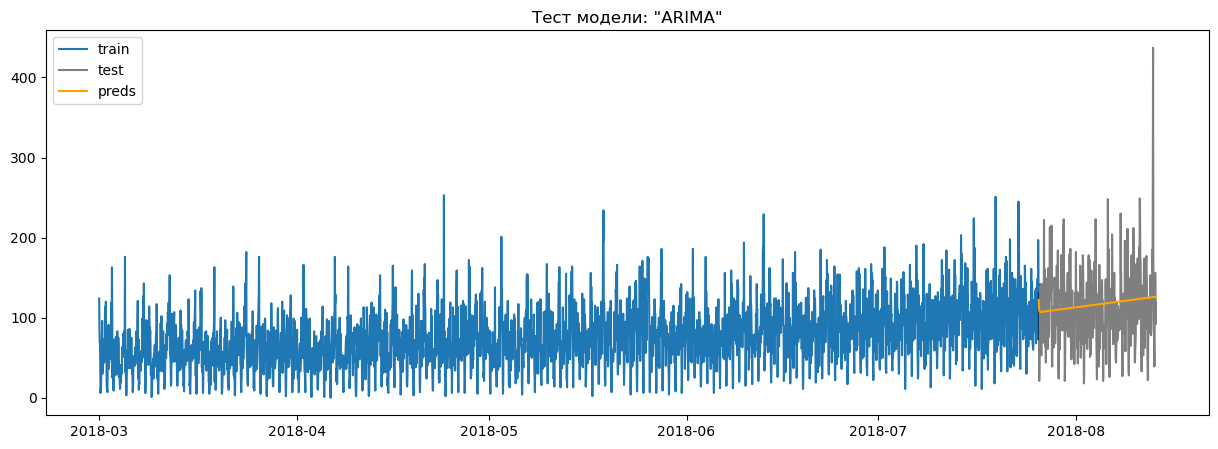

Модель "ARIMA", показала следующий результат RMSE: 46.32


In [17]:
# RMSE - уже гораздо лучше. Попробуем протестировать модель:
arima_model = ARIMA(train, order=best_order)
arima_results = arima_model.fit()
preds_arima = arima_results.forecast(steps=len(test))

estimator_func(train, validation, preds_arima, 'ARIMA')

**На валидационных данных ARIMA - недостаточно эффективна. Модель уловила тренд, но этого недостаточно. Можно было бы поэксперементировать ещё с моделью SARIMA, но есть вероятность, что данных много и они слишком сложные для базовых статистических моделей. В связи с этим, предлагаю перейти к линейным моделям машинного обучения. Однако, для этого, нужно немного подготовить наши признаки.**

###  Создание дополнительных признаков и определение тестовых данных;

Для эффективного моделирования, стоит ещё раз прокачать наши данные. 

In [18]:
def make_features(df_input, max_lag, target, rolling_mean_size):
    """
    Генерирует дополнительные признаки для заданного DataFrame.

    Параметры:
        df_input (pd.DataFrame): Входной DataFrame.
        max_lag (int): Максимальное значение задержки для создания лаг-признаков.
        target (str): Название целевой колонки для лаг-признаков.
        rolling_mean_size (int): Размер окна для вычисления скользящего среднего.

    Возвращает:
        pd.DataFrame: Входной DataFrame с добавленными признаками.
    """
    df_input['day'] = df_input.index.day
    df_input['dayofweek'] = df_input.index.dayofweek
    df_input['hour'] = df_input.index.hour
    
    for lag in range(1, max_lag + 1):
        df_input[f'lag_{lag}'] = df_input[target].shift(lag, fill_value=0)

    df_input['rolling_mean'] = df_input[target].shift(fill_value=0).rolling(rolling_mean_size).mean().fillna(method='bfill')
    return df_input


# возьмём 6 лагов, интуитивно, кажется, что поскольку у нас во времени 4 категории: "утро", "день", "вечер", "ночь". 
# Правильно будет охватывать полностью период
df_features = make_features(df_input=df, max_lag=6, target='num_orders', rolling_mean_size = 3) 

In [19]:
# разделим преобразованные данные, для будушего тестирования модели
train, validation, test = split_function(df_features)

X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

### Тренировка линейной регресси

In [20]:
## Далее применим кросс валидацию для оценки модели:
tscv = TimeSeriesSplit(n_splits=5)
scores = []

# Проход по разбиениям временной кросс-валидации
for train_index, val_index in tscv.split(train):
    
    train_batch, val_batch = train.iloc[train_index], train.iloc[val_index]

    X_train, X_val = train_batch.drop(columns=['num_orders']), val_batch.drop(columns=['num_orders'])
    y_train, y_val = train_batch.num_orders, val_batch.num_orders

    # Инициализация и обучение модели
    model = LinearRegression()
    model.fit(X_train, y_train)

    preds_val = model.predict(X_val)
    scores.append(np.sqrt(mean_squared_error(preds_val, y_val)))

print('RMSE целевой модели:', round(np.array(scores).mean(), 1))

RMSE целевой модели: 31.1


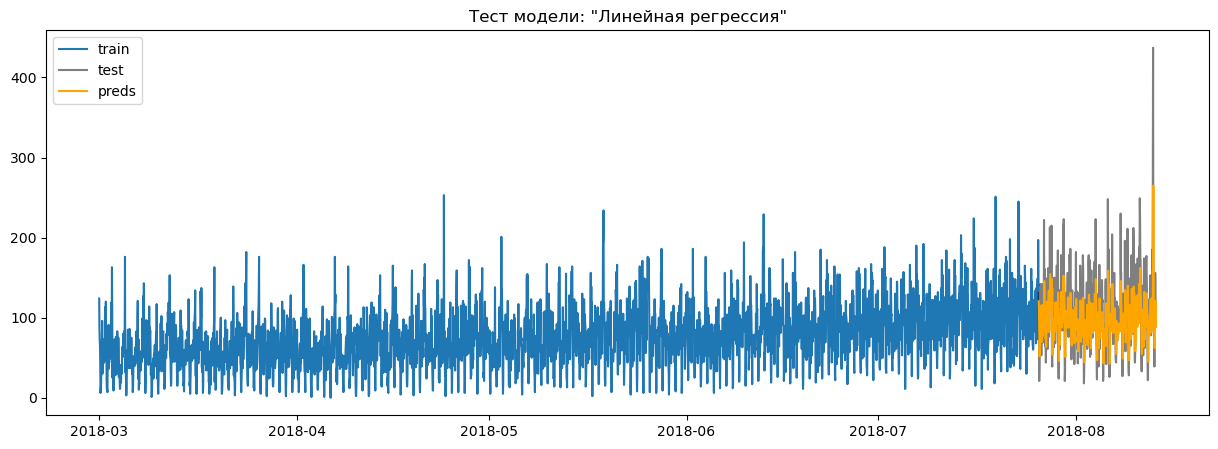

Модель "Линейная регрессия", показала следующий результат RMSE: 43.6


In [21]:
model = LinearRegression()
model.fit(train.drop(columns=['num_orders']), train.num_orders)
preds_linear = model.predict(validation.drop(columns=['num_orders']))

estimator_func(train.num_orders, validation.num_orders, preds_linear, 'Линейная регрессия')

**Здесь, мы видим, уже явно более эффективное прогнозирование. В целом, результат 43,6 уже соотвествует заявленым требованиям. Однако, перед тем как тестировать модель на тестовых данных, хочется проверить ещё LSTM. Если результаты её валидации будут ощутимо лучше, то будем тестировать и дообучать её.**

### Подготовка данных к LSTM

*Для нейросетевых архитектур, очень важно прибегать к кодировщикам. Мы применим ColumnTransformer, который преобразует категориальные и числовые значения.*

In [22]:
categorical_features = ['day', 'dayofweek', 'hour']
numeric_features = [tc for tc in train.columns if tc not in categorical_features]
target = ['num_orders']
numeric_features.remove('num_orders')

col_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical_features)],     
    remainder="passthrough"
)

X_train = torch.Tensor((col_transformer.fit_transform(train)))
X_val = torch.Tensor((col_transformer.transform(validation)))
X_test = torch.Tensor((col_transformer.transform(test)))

y_train = torch.Tensor(train[target].values)
y_val = torch.Tensor(validation[target].values)
y_test = torch.Tensor(test[target].values)

# Создание DataLoader для обучения, валидации и тестирования
batch_size = 216  # Размер пакета (batch size)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# инциализируем архитектуру LSTM
class LSTMpredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMpredictor, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [24]:
# определим функции для обучения и предсказания модели
def train_model(model, train_loader, loss_func, optimizer, num_epochs):
    model.train() 
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad() 
            inputs = inputs.float()
            targets = targets.float()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)  
            loss.backward()
            optimizer.step()

def evaluate_model(model, val_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, targets_batch in val_loader:
            inputs = inputs.float()
            targets_batch = targets_batch.float()
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            targets.extend(targets_batch.cpu().numpy())
    return predictions

In [25]:
# Создайте набор значений для гиперпараметров
hidden_sizes = [64, 128, 216]
learning_rates = [0.001, 0.01, 0.1]
num_layers = [1, 2]

best_model_params = None
best_val_mse = 1000


for h_s, lr_, n_l in tqdm(itertools.product(hidden_sizes, learning_rates, num_layers),
                                                  total=len(hidden_sizes) * len(learning_rates) * len(num_layers)) :
    model = LSTMpredictor(X_train.size()[1], h_s, num_layers=n_l)
    loss_func = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_)
    num_epochs = 100
    train_model(model, train_loader, loss_func, optimizer, num_epochs)
    preds = evaluate_model(model, val_loader)
    mse = mean_squared_error(preds, y_val)
    if mse < best_val_mse:
        best_model_params = [h_s, lr_, n_l]
        best_val_mse = mse
        print(np.sqrt(mse))
    

 17%|█████████████▊                                                                     | 3/18 [01:07<05:35, 22.39s/it]

18.660162


 22%|██████████████████▍                                                                | 4/18 [01:40<06:11, 26.52s/it]

16.97481


 28%|███████████████████████                                                            | 5/18 [02:00<05:15, 24.26s/it]

16.324081


 50%|█████████████████████████████████████████▌                                         | 9/18 [04:24<04:56, 32.93s/it]

13.696504


 61%|██████████████████████████████████████████████████                                | 11/18 [05:50<04:21, 37.40s/it]

12.0264


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [11:29<00:00, 38.29s/it]


In [29]:
best_model_params

[128, 0.1, 1]

## Тестирование

In [26]:
# для начала соединим тренировочные и валидационные данные, чтобы переобучить модель
X_train_full = torch.cat((X_train, X_val))
y_train_full = torch.cat((y_train, y_val))

train_dataset_full = TensorDataset(X_train_full, y_train_full)
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=True)

In [27]:
model_finally = LSTMpredictor(X_train.size()[1], best_model_params[0], best_model_params[2])

# Функция потерь (например, для задачи регрессии)
loss_func = nn.MSELoss()

# Оптимизатор
optimizer = optim.Adam(model_finally.parameters(), lr=best_model_params[1]) 

num_epochs = 100  # Количество эпох обучения
train_model(model_finally, train_loader_full, loss_func, optimizer, num_epochs)

# Оценка модели на тестовых данных
test_predictions = evaluate_model(model_finally, test_loader)

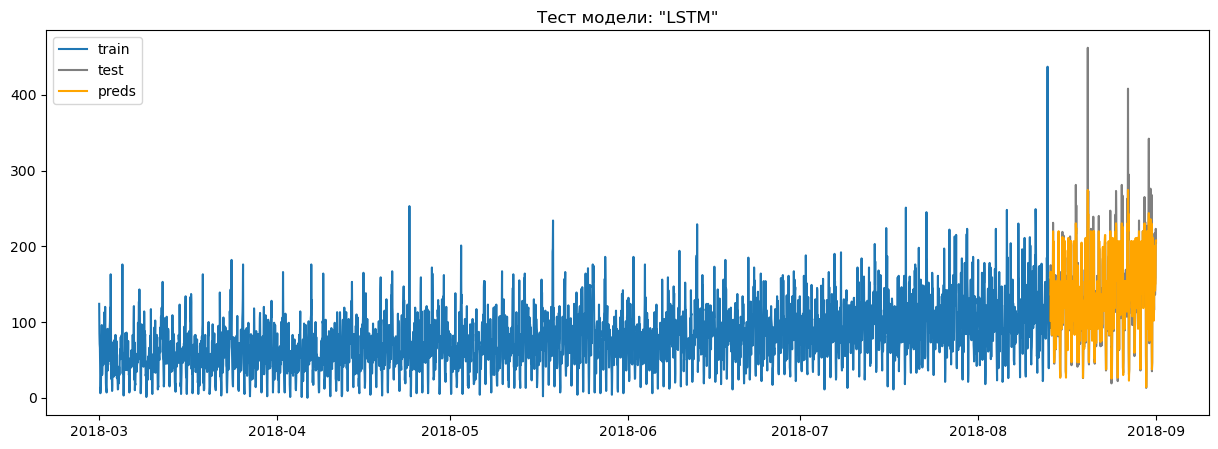

Модель "LSTM", показала следующий результат RMSE: 16.290000915527344


In [28]:
vis_res_train = pd.DataFrame(np.array(y_train_full), index=pd.concat([train, validation]).index)
vis_res_test = pd.DataFrame(np.array(y_test), index=test.index)
vis_res_pred = pd.DataFrame({'preds': np.concatenate(np.array(test_predictions))}, index=test.index)

plt.figure(figsize=(15, 5))
plt.plot(vis_res_train)
plt.plot(vis_res_test, alpha=0.5, color='black')
plt.plot(vis_res_pred, color='orange')
plt.title(f'Тест модели: "LSTM"')
plt.legend(['train', 'test', 'preds'])
plt.show()
    
mse = mean_squared_error(vis_res_pred, vis_res_test[vis_res_test.columns[0]].values) 
print(f'Модель "LSTM", показала следующий результат RMSE: {round(np.sqrt(mse), 2)}')

**Вывод:**

    В ходе эксперимента было проверенно 5 моделей:
            1.1 - модель, которая подставляет медиану;
            1.2 - модель, которая подставляет последнее известное значение
            1.3 - ARIMA
            1.4 - Линейную регрессию
            1.5 - LSTM
    В результате исследования, лучшей моделью оказалась модель "LSTM", которая способна предсказывать целевое значнение на час, с точностью в 16 RMSE на тестовых данных.